### MAML Tutorial with JAX

Eric Jang


Blog post: https://blog.evjang.com/2019/02/maml-jax.html

### Overview
- How to take gradients, gradients of gradients
- Hot to fit a sinusoid funciton with a neural network (and do auto-batching with vmap)
- How to implement MAML and check its numerics
- How to implement MAML for sinusoid task (single-task objective, batching task instances).
- Extending MAML to handle batching at the task-level



In [0]:
import jax.numpy as np
from jax import grad

### Gradients of Gradients
JAX makes it easy to compute gradients of python functions. Here, we thrice-differentiate $e^x$ and $x^2$

In [2]:
f = lambda x: np.exp(x)
g = lambda x: np.square(x)

print(grad(f)(1.)) # = e^{1}
print(grad(grad(f))(1.))
print(grad(grad(grad(f)))(1.))

print(grad(g)(2.)) # 2x = 4
print(grad(grad(g))(2.)) # x = 2
print(grad(grad(grad(g)))(2.)) # x = 0

2.7182817
2.7182817
2.7182817
4.0
2.0
0.0


### Sinusoid Regression and vmap
We will optimize neural network params with fixed inputs ona mean-squared error loss to $f_{\theta}(x) = \sin(x)$.

In [0]:
from jax import vmap # For auto-vectorizing functions
from functools import partial # For use with vmap
from jax import jit # For compiling functions for speedup
from jax.experimental import stax # Neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # Neural network layers
from jax import random
import matplotlib.pyplot as plt # Visualization

In [0]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1)
)
in_shape = (-1, 1,)
rng = random.PRNGKey(0)
out_shape, net_params = net_init(rng, in_shape)

In [0]:
def loss(params, inputs, targets):
  """Computes average loss for the batch"""
  predictions = net_apply(params, inputs)
  return np.mean((targets - predictions) ** 2)

In [0]:
# Batch the inference accross K=100
xrange_inputs = np.linspace(-5, 5, 100).reshape((100, 1))
# (k, 1)
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # Per-input loss

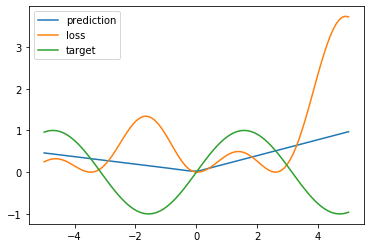

In [14]:
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

In [0]:
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap # Element-wise manipulation of collections of numpy arrays

In [0]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(net_params)

In [0]:
# Define a compiled update step
@jit
def step(i, opt_state, x1, y1):
  p = get_params(opt_state)
  g = grad(loss)(p, x1, y1)
  return opt_update(i, g, opt_state)

In [0]:
for i in range(100):
  opt_state = step(i, opt_state, xrange_inputs, targets)

In [0]:
net_params = get_params(opt_state)

In [0]:
# Batch the inference across K=100
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # Per-input loss

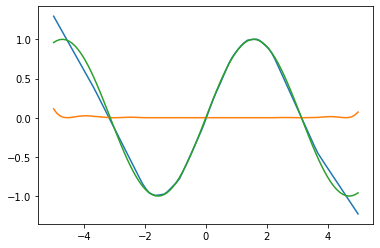

In [21]:
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')

### Sinusoid Task + MAML

In [0]:
alpha = .1
def inner_update(p, x1, y1):
  grads = grad(loss)(p, x1, y1)
  inner_sgd_fn = lambda g, state: (state - alpha * g)
  return tree_multimap(inner_sgd_fn, grads, p)

In [0]:
def maml_loss(p, x1, y1, x2, y2):
  p2 = inner_update(p, x1, y1)
  return loss(p2, x2, y2)

In [25]:
x1 = xrange_inputs
y1 = targets
x2 = np.array([0.])
y2 = np.array([0.])
maml_loss(net_params, x1, y1, x2, y2)

DeviceArray(0.00021757, dtype=float32)

Let's try minimizing the MAML loss (without batching across multiple tasks, which we will do in the next section)

In [0]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

In [0]:
@jit
def step(i, opt_state, x1, y1, x2, y2):
  p = get_params(opt_state)
  g = grad(maml_loss)(p, x1, y1, x2, y2)
  l = maml_loss(p, x1, y1, x2, y2)
  return opt_update(i, g, opt_state), l

In [0]:
K = 20
np_maml_loss = []

In [41]:
for i in range(20000):
  # Define the task
  A = onp.random.uniform(low=0.1, high=.5)
  phase = onp.random.uniform(low=0., high=np.pi)
  # Meta-training inner split (K examples)
  x1 = onp.random.uniform(low=-5., high=5., size=(K, 1))
  y1 = A * onp.sin(x1 + phase)

  # Meta-training outer split (1 example).
  # Like cross-validating with respect to one example.
  x2 = onp.random.uniform(low=-5., high=5.)
  y2 = A * onp.sign(x2 + phase)
  opt_state, l = step(i, opt_state, x1, y1, x2, y2)
  np_maml_loss.append(l)

  if i % 1000 == 0:
    print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


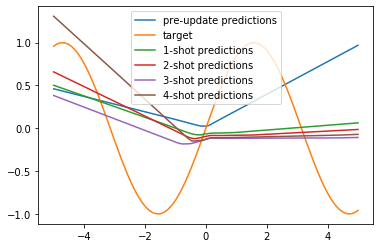

In [43]:
# Batch the inference across K=100
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5, high=5., size=(K, 1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1, 5):
  net_params = inner_update(net_params, x1, y1)
  predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
  plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

### Batching Meta-Gradient Across Tasks
Kind of does the job but not that great. Let's reduce the variance of gradients in outer loop by averaging across a batch of tasks (not just one task at a time).

vamp is nice handling of batching at two levels: inner-level "intra-task" batching, and outer level batching across tasks.

From a software engineering perspective, it is nice because "task-batched" MAMP implementation simply re-uses code from the non-task batcked MAML algorithm, without losing any vectorization benefits.

In [0]:
def sample_tasks(outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(onp.random.uniform(low=0.1, high=.5))
        phases.append(onp.random.uniform(low=0., high=np.pi))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = onp.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * onp.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2

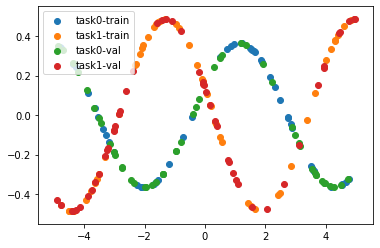

In [51]:
outer_batch_size = 2
x1, y1, x2, y2 = sample_tasks(outer_batch_size, 50)
for i in range(outer_batch_size):
  plt.scatter(x1[i], y1[i], label='task{}-train'.format(i))
for i in range(outer_batch_size):
  plt.scatter(x2[i], y2[i], label='task{}-val'.format(i))
plt.legend()

In [52]:
x2.shape

(2, 50, 1)

In [0]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

In [0]:
# vmapped version of maml loss.
# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
  task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
  return np.mean(task_losses)

In [0]:
@jit
def step(i, opt_state, x1, y1, x2, y2):
  p = get_params(opt_state)
  g = grad(batch_maml_loss)(p, x1, y1, x2, y2)
  l = batch_maml_loss(p, x1, y1, x2, y2)
  return opt_update(i, g, opt_state), l 

In [66]:
np_batched_maml_loss = []
K = 20
for i in range(20000):
  x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K)
  opt_state, l = step(i, opt_state, x1_b, y1_b, x2_b, y2_b)
  np_batched_maml_loss.append(i)
  if i % 1000 == 0:
    print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


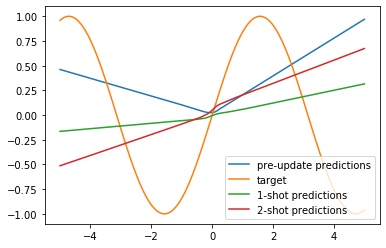

In [67]:
# Batch the inference across K=100
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(-5., 5., size=(10, 1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1, 3):
  net_params = inner_update(net_params, x1, y1)
  predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
  plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

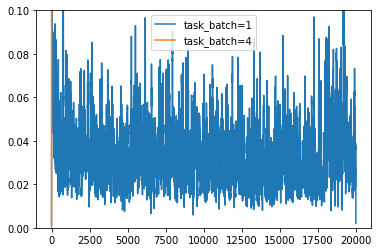

In [68]:
# Comparison of maml_loss for task batch size = 1 vs task batch size = 8
plt.plot(onp.convolve(np_maml_loss, [.05] * 20), label='task_batch=1')
plt.plot(onp.convolve(np_batched_maml_loss, [.05] * 20), label='task_batch=4')
plt.ylim(0., 1e-1)
plt.legend()